<a href="https://colab.research.google.com/github/jonathanchau/Media-Analysis/blob/main/ML_Model_COGS9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from collections import Counter
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from textblob.classifiers import DecisionTreeClassifier
import scipy.stats
import sklearn.linear_model
import sklearn.discriminant_analysis
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.linear_model as lm
from sklearn import metrics
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
!pip install swifter
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 8.6 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=d1824dbae30b5657f84194ff6d7a27149dab1da62b7216bdcc3b18c6f3444a57
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: fi

In [ ]:
# Hide annoying pandas warning
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Importing Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowdflower/political-social-media-posts")

print("Path to dataset files:", path)

100%|██████████| 800k/800k [00:00<00:00, 60.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/crowdflower/political-social-media-posts/versions/1


In [ ]:

!pip install kaggle
from google.colab import files

# Upload your kaggle.json file
files.upload()

# Move kaggle.json to the Kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Replace 'crowdflower/political-social-media-posts' with the Kaggle dataset name
!kaggle datasets download -d crowdflower/political-social-media-posts

# Unzip the dataset
!unzip political-social-media-posts.zip

In [ ]:
# Reading in csv
text_df = pd.read_csv("political_social_media.csv", encoding='ISO-8859-1')
text_df.head()

# Cleaning Data

In [ ]:
# Making a copy of the df incase needing to revert back due to error
clean_df = text_df.copy()

In [ ]:
# Remove columns to keep only those subject to analysis
clean_df = text_df[['_unit_id', 'text', 'label', 'bias', 'message']]
clean_df.head()

In [ ]:
# --- Converting to lowercase ---

# Preserve 'US' by replacing it with a placeholder
clean_df.loc[:, 'text'] = clean_df['text'].str.replace(r'\bUS\b', 'PLACEHOLDER_US', regex=True)

# Convert all text to lowercase for standardization
clean_df.loc[:, 'text'] = clean_df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Restore 'US' from the placeholder
clean_df.loc[:, 'text'] = clean_df['text'].str.replace('placeholder_us', 'US', regex=False)

# Display cleaned text
clean_df['text'].head()

In [ ]:
import re  # "regular expressions" very useful for parsing text, looking for patterns, etc.

# Define unwanted characters and patterns
to_remove = [
    r'@\S+', # Matches @username
    r'[^\w\s]',  # Non-word characters except spaces
    r'#', r'-', r'"', r';', r':', r'%', r'\^', r'&', r'\*', r',', r'fl', r'ª', r'û',r'ò'  # Specific symbols
    r'&amp;', r'\bamp\b',  # HTML entities
    r'\brt\b',  # Matches 'rt' as a standalone word
    r'http\S+'  # Matches http links
]

# Clean the text
for pattern in to_remove:
    clean_df.loc[:, 'text'] = clean_df['text'].str.replace(pattern, '', regex=True)

# sometimes in the text there were random ' r ' characters so i had to remove those manually
clean_df.loc[:, 'text'] = clean_df['text'].str.replace(r'\s+r\s+', ' ', regex=True)

# Remove extra spaces
clean_df.loc[:, 'text'] = clean_df['text'].str.strip().str.replace(r'\s+', ' ', regex=True)

# Display cleaned text
clean_df.loc[:, 'text']


In [ ]:
# Remove filler words such as "and," "the," "is" that are generally considered irrelevant for NLP.
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')
clean_df.loc[:, 'text'] = clean_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
clean_df['text']

In [ ]:
freq = pd.Series(' '.join(clean_df['text']).split()).value_counts()
#freq[-20:] #least common words
#freq[:20] #most common words
freq

In [ ]:
# Optional/Not Implemented - remove less frequent words to reduce vocabulary clutter. This step can help ml model train quicker, and or improve accuracy.
# But it may not be smart because our dataset is relatively small, and removing these small words may throw out important contextual data.
# Also, Roberta is capable of tokenizing uncommon words in a way that extracts use out of them regardless.

Spell correction using FastText library and Swifter library.
1. Swifter is a parallel computing library that is well optimized for pandas
.apply() function. Not entirely useful for this small dataset but could save time with larger ones.
2. FastText is context-aware, meaning it can infer spelling corrections even for out-of-vocabulary words by breaking them down into subword units.
Best for applications requiring a more flexible and adaptable correction system, such as analyzing user-generated content.

In [ ]:
# Download pre-trained FastText model (English wiki)
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

In [ ]:
import swifter
import fasttext


def fasttext_correct(text):
    corrected_text = []
    for word in text.split():
        prediction = model.predict(word)  # Predict language and confidence
        if prediction[1][0] > 0.5:
            corrected_text.append(word)
        else:
            # Use FastText to suggest similar words
            similar_words = model.get_nearest_neighbors(word)
            if similar_words:
                corrected_text.append(similar_words[0][1])  # Choose closest match
            else:
                corrected_text.append(word)  # Keep the original if no match found
    return ' '.join(corrected_text)


In [ ]:
# Apply spelling correction to the DataFrame
clean_df['text'] = clean_df['text'].swifter.apply(fasttext_correct)

In [ ]:
#TODO: Drop rows where there is no TEXT variable

# Pre ML EDA

In [ ]:
eda_df = clean_df

Prepare Bias and Message Columns to Categorical


In [ ]:
# Convert the bias and message columns to categorical (this will be helpful for classification methods later on)
eda_df.bias = pd.Categorical(eda_df.bias)
eda_df.message = pd.Categorical(eda_df.message)

Create a "vector" column with vectorized "text" field.

In [ ]:
eda_df['vector'] = [i for i in eda_df.text.str.split(" ")]

In [ ]:
# Let's now look at the first 10 rows (capitalized column headers)
eda_df.bias = pd.Categorical(eda_df.bias)
renameColumns = {'bias' : 'BIAS', 'message' : 'MESSAGE', 'label' : 'LABEL', 'text' : 'TEXT', 'vector' : 'VECTOR'}
eda_df.rename(mapper = renameColumns, axis = 1, inplace=True)
eda_df.head(10)

In [ ]:
#Again let's look at the type of values for the remaining columns
for column in eda_df.columns:
    print("%s       \t# of unique values: %s,   \tdtype: %s" % (column, len(np.unique(eda_df[column].values)), eda_df[column].dtype))

In [ ]:
print("There are {} observations and {} features in this dataset. \n".format(eda_df.shape[0],eda_df.shape[1]))

In [ ]:
count_words = Counter()
eda_df.VECTOR.apply(count_words.update)
print('MOST COMMON WORD (COUNT):\n', count_words.most_common(50))
print('\n\n')
print('LEAST COMMON WORD (COUNT):\n', count_words.most_common()[-250:-200])

In [ ]:
x = eda_df.MESSAGE.unique()
y = eda_df.MESSAGE.value_counts()
plt.bar(x, y);
plt.xticks(rotation=30);
plt.ylabel('Frequency');

In [ ]:
print("Total Messages:\n",eda_df.MESSAGE.describe())
print("\nBiased word choices:\n",eda_df.BIAS.describe())

In [ ]:
data = eda_df['LABEL'].iloc[:]
states = data.groupby(eda_df['LABEL']).count()
states.sort_values(ascending=False)

In [ ]:
ptext = " ".join(review for review in eda_df.TEXT)
print ("There are {} words in the combination of all tweets.".format(len(ptext)))

# Machine Learning

So right now, we want to train a model to predict one of 3 bias categories for each tweet. **Left, right, and neutral**. The problem is, the current dataset we are using only has 2 categories; **neutral and partisan**. This don't work unc!!!!!! Im gonna try to reclassify the data somehow.

Testing k means clustering to seperate text into 'left' 'neutral' and 'right' bias categories. This prob wont work lol


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud

In [ ]:
ml_df = eda_df

NameError: name 'eda_df' is not defined

In [ ]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(ml_df['TEXT'])

# Apply K-Means clustering to find 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
ml_df['cluster'] = kmeans.fit_predict(X)

# Use PCA for dimensionality reduction to visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

ml_df['pca1'] = X_pca[:, 0]
ml_df['pca2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue=ml_df['cluster'], palette='viridis', data=ml_df)
plt.title('Clustering of Political Tweets (K-Means + PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster", labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.show()

# Generate WordClouds for each cluster
for cluster in range(3):
    cluster_text = ' '.join(ml_df[ml_df['cluster'] == cluster]['TEXT'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

Okay so that definitely DID NOT work unc... Unless it did and we just need to look at it in 3 dimensions.
I am going to attempt zero-shot classification. basically i just have facebooks bart come in and reclassify the data for us with its smart little ai brain into 3 groups ('neutral, 'left', and 'right'). and my 2019 macbook has an Intel i5!!! I dont think this will ever finish running.

In [ ]:
# Initialize the zero-shot classification pipeline using bart
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Same as the code below except this code doesnt give a confidence score of the predicted label. I think a confidence score would be nice so maybe dont run this cell.

# Define candidate labels for classification
candidate_labels = ["left", "neutral", "right"]

# Function to classify a single tweet
def classify_text(text):
    result = classifier(text, candidate_labels=candidate_labels)
    return result['labels'][0]  # The highest scoring label

# Apply the classification function to the 'TEXT' column
ml_df['PREDICTED_BIAS'] = ml_df['TEXT'].apply(classify_text)

# Display some sample results
print(ml_df[['TEXT', 'BIAS', 'PREDICTED_BIAS']].head())

NameError: name 'ml_df' is not defined

In [ ]:
# with confidence score

# Define candidate labels for classification
candidate_labels = ["left", "neutral", "right"]

# Function to get the confidence score of the predicted label
def classify_text_with_score(text):
    result = classifier(text, candidate_labels=candidate_labels)
    return pd.Series({'PREDICTED_BIAS': result['labels'][0], 'CONFIDENCE': result['scores'][0]})

# Apply classification and extract scores
ml_df[['PREDICTED_BIAS', 'CONFIDENCE']] = ml_df['TEXT'].apply(classify_text_with_score)

# Summary statistics of confidence scores
print("\nConfidence Score Summary:")
print(ml_df['CONFIDENCE'].describe())

# Plot distribution of confidence scores
plt.figure(figsize=(8,5))
sns.histplot(ml_df['CONFIDENCE'], bins=20, kde=True)
plt.title("Confidence Score Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()

I think this error occured because we have rows with no text in them. Still need to go back to data cleaning and fix that.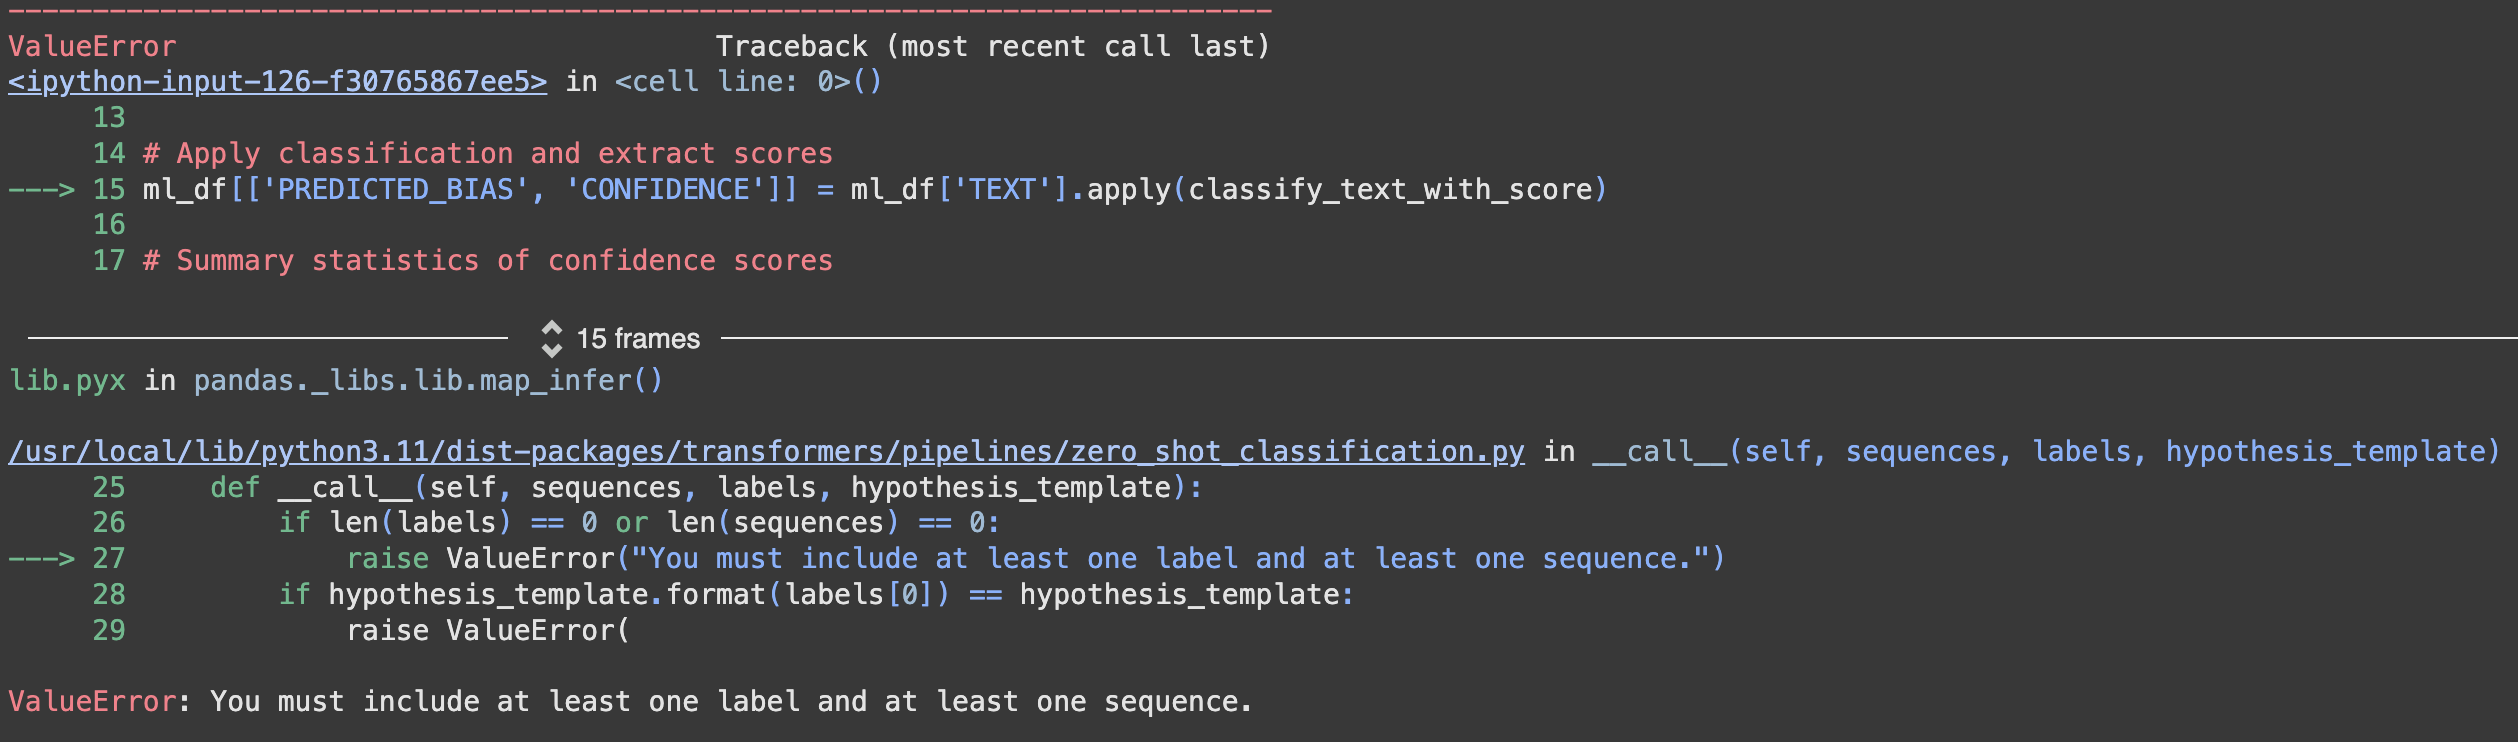




This code basically just makes a confusion matrix but I think it will kinda suck. All it really tells us is if the reclassification was able to effectively detect the 'partisan' rows and classify them as either 'right' or 'left', and the 'neutral' rows as 'neutral'. I dont really know how confusion matrices work but it cant be that confusing right. haha guys do u get it.

In [ ]:
# Convert actual and predicted labels to numeric values
label_mapping = {'neutral': 0, 'partisan': 1}
ml_df['BIAS_NUM'] = ml_df['BIAS'].map(label_mapping)
ml_df['PREDICTED_BIAS_NUM'] = ml_df['PREDICTED_BIAS'].replace({'left': 'partisan', 'right': 'partisan', 'neutral': 'neutral'}).map(label_mapping)

# Generate the confusion matrix
conf_matrix = confusion_matrix(ml_df['BIAS_NUM'], ml_df['PREDICTED_BIAS_NUM'])

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Neutral vs Partisan)")
plt.show()

# Print classification report
print("Classification Report:\n")
print(classification_report(ml_df['BIAS_NUM'], ml_df['PREDICTED_BIAS_NUM'], target_names=label_mapping.keys()))


In [ ]:
!pip install transformers torch

Here is our official machine learning model, RoBERTa from hugging face. Now, let's get ready to rumbleeeeeeeeeeeeeee

# RoBERTa

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
def analyze_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Pass the input through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get the predicted sentiment label
    sentiment_label = torch.argmax(probs, dim=1).item()

    # Map the label to a sentiment
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = sentiment_map[sentiment_label]

    return sentiment, probs

In [ ]:
# Example text
text = "Hello, world"

# Analyze sentiment
sentiment, probs = analyze_sentiment(text)
print(f"Sentiment: {sentiment}")
print(f"Probabilities: Negative: {probs[0][0]:.4f}, Neutral: {probs[0][1]:.4f}, Positive: {probs[0][2]:.4f}")

Sentiment: Positive
Probabilities: Negative: 0.0434, Neutral: 0.4247, Positive: 0.5319
